Выполнил студент Андрющенко К.С.

1. Для построения BWT можете брать библиотечный суффиксный массив
2. Делаете BWT+MTF+(RLE или ZLE, как хотите)+ARI, иначе результат будет слабый (в качестве последней стадии сравните ARI и HUF)
3. Тестируете на своей книге (в исходном и в декапитализированном виде), а потом исследуете любой желаемый вид файлов. 

*Про картинки я скорее пессимистичен, что будет с сериализацией нейросетей — не берусь предсказать, прооверьте.*

Построение BWT с использованием библиотечного суффиксного массива (наиболее быстрая реализация, вроде O(n)). Также напишем обратное преобразование.

In [100]:
#%pip install pydivsufsort
#%pip install pydivsufsort numpy

In [101]:
import pydivsufsort
import numpy as np
from math import ceil, floor
from os.path import commonprefix
from collections import Counter
import math
import numpy as np
import time
import collections

### Задание 1-2. Для проверки используется простой пример.

In [102]:
def bwt_suffix_arr(text: str) -> (str, int):
    # добавление специального символа конца текста # либо /x00
    if not text:
        return "", -1
    # if not text.endswith('#'):
    #     text += '#'
    text += '\x00'
    
    byte_array = (text).encode('utf-8')  
    n_bytes = len(byte_array)

    sa = pydivsufsort.divsufsort(np.frombuffer(byte_array, dtype=np.uint8).copy())

    bwt_bytes = np.empty(n_bytes, dtype=np.uint8)
    original_row_index = -1

    for i in range(n_bytes):
        suffix_start_index = sa[i]
        if suffix_start_index == 0:
            original_row_index = i
            bwt_bytes[i] = byte_array[n_bytes - 1]
        else:
            bwt_bytes[i] = byte_array[suffix_start_index - 1]

    if original_row_index == -1:
        raise RuntimeError("Original index not found.")

    return bwt_bytes.tobytes().decode('latin-1'), original_row_index

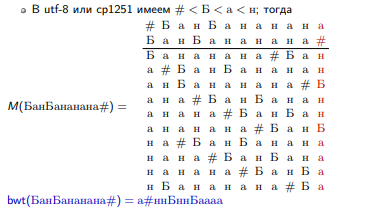

T = БанБананана#

"#" символ конца текста, он будет замене на символ "\x00" (байтовое значение равно 0), который гарантированно не встречается, при текстовом выводе на месте данного символа будет пропуск

In [103]:
text = "BanBananana"
print(f"Исходный текст: '{text}'\n")
bwt_result, indx = bwt_suffix_arr(text)
bwt_result = bwt_result.encode('latin-1').decode('utf-8')
print(f"\nИтоговая BWT-строка: {bwt_result}, {indx}")

Исходный текст: 'BanBananana'


Итоговая BWT-строка: a nnBnnBaaaa, 1


Обратное преобразование

На вход: сама строка BWT и номер строки исходного текста в M(T) (в лекции было Номер i нужной строки — это позиция # в bwt(T), т.е. позиция символа конца текста (оригинального))

In [104]:
def bwt_decode(bwt_string: str, original_row_index: int) -> str:
    # декодирование BWT, с учетом наличия спец символа в конце

    if not bwt_string:
        return ""

    bwt_array = np.frombuffer(bwt_string.encode('latin-1'), dtype=np.uint8)
    n = len(bwt_array)

    char_counts = np.zeros(256, dtype=np.int32)
    for byte_val in bwt_array:
        char_counts[byte_val] += 1

    char_start_positions = np.zeros(256, dtype=np.int32)
    for i in range(1, 256):
        char_start_positions[i] = char_start_positions[i-1] + char_counts[i-1]

    lf_mapping = np.zeros(n, dtype=np.int32)
    for i in range(n):
        char = bwt_array[i]
        lf_mapping[i] = char_start_positions[char]
        char_start_positions[char] += 1

    decoded_array = np.empty(n, dtype=np.uint8)
    current_index = original_row_index

    for i in range(n - 1, -1, -1):
        decoded_array[i] = bwt_array[current_index]
        current_index = lf_mapping[current_index]

    decoded_bytes = decoded_array.tobytes()

    # Удаляем — символ конца строки
    hash_byte_value = ord('\x00')
    if decoded_bytes[-1] != hash_byte_value:
        raise ValueError("Decoded string does not end with expected null byte.")
    
    return decoded_bytes[:-1].decode('utf-8')


In [105]:
bwt_result, eof_pos = bwt_suffix_arr(text)
decoded_text = bwt_decode(bwt_result, eof_pos)
print(f"декодированная строка: {decoded_text}")
# gроверка
original_text = text
print(f"Декодированный текст совпадает с исходным: {decoded_text == original_text}")

декодированная строка: BanBananana
Декодированный текст совпадает с исходным: True


Метод стопки книг (MTF)

(MTF) читает входную строку слева направо и посимвольно меняет ее по следующим правилам:   
* Алфавит упорядочен, все символы адресуются своими номерами в списке
(первый элемент имеет номер 0)   
* Очередной символ a заменяется на номер a в текущем списке, после чего
a перемещается в начало списка (получает номер 0)    
* у каждого символа с номером меньшим номера a номер увеличивается на 1

Алфавит заранее согласуем, передавать его не надо (учитывая что это предназначено для кодирования текста состоящего из цифр и маленьких букв, можно будет урезать диапазон наверное или же вернуться к созданию оптимального алфавита, а потом передавать его декдеру)

In [106]:
def mtf_encode(text: str) -> list[int]:
    # используется фиксированный, заранее определенный алфавит (все байты от 0 до 255)
    alphabet = [chr(i) for i in range(256)]
    encoded_output = []
    for char in text:
        try:
            rank = alphabet.index(char)
        except ValueError:
            # символы не из диапазона
            raise ValueError(f"символ '{char}' не найден в фиксированном алфавите")
        encoded_output.append(rank)
        # Перемещаем символ в начало списка
        char_to_move = alphabet.pop(rank)
        alphabet.insert(0, char_to_move)
    return encoded_output

def mtf_decode(encoded_data: list[int]) -> str:
    # для декодирования нам нужен точно такой же начальный алфавит он заранее известен
    alphabet = sorted(list(set(chr(i) for i in range(256)))) 
    decoded_chars = []
    for rank in encoded_data:
        # символ по его номеру (индексу)
        char = alphabet[rank]
        decoded_chars.append(char)
        # реремещаем этот символ в начало алфавита
        char_to_move = alphabet.pop(rank)
        alphabet.insert(0, char_to_move)
    return "".join(decoded_chars)

In [107]:
# кодирование
bwt_result, eof_pos = bwt_suffix_arr(text)
mtf_result = mtf_encode(bwt_result)
print(f"\nРезультат MTF-кодирования: {mtf_result}")

# декодирование
decoded_string = mtf_decode(mtf_result)
print(f"Декодированная строка: '{decoded_string}'")
print(f"Декодирование успешно: {decoded_string == bwt_result}")


Результат MTF-кодирования: [97, 1, 110, 0, 68, 1, 0, 1, 3, 0, 0, 0]
Декодированная строка: 'a nnBnnBaaaa'
Декодирование успешно: True


RLE

Каждую последовательность нулей заменяем на 0 и длину последовательности
список длин кодируем отдельно

In [108]:
def rle_encode(mtf_output):
    if not mtf_output:
        return [], []
    values = []
    frequencies = []
    current_value = mtf_output[0]
    count = 1
    
    for value in mtf_output[1:]:
        if value == current_value:
            count += 1
        else:
            values.append(current_value)
            frequencies.append(count)
            current_value = value
            count = 1
    values.append(current_value)
    frequencies.append(count)
    return values, frequencies

In [109]:
def rle_decode(values, frequencies):
    if len(values) != len(frequencies):
        raise ValueError("Длины списков 'values' и 'frequencies' не совпадают.")
    
    decoded = []
    for value, freq in zip(values, frequencies):
        decoded.extend([value] * freq)
    return decoded

In [110]:
rle_values, rle_freqs = rle_encode(mtf_result)
print("Значения", rle_values) 
print("Частоты ", rle_freqs) 

Значения [97, 1, 110, 0, 68, 1, 0, 1, 3, 0]
Частоты  [1, 1, 1, 1, 1, 1, 1, 1, 1, 3]


In [111]:
decoded_result = rle_decode(rle_values, rle_freqs)
print("Восстановлено:", decoded_result)
print(f"Декодирование успешно: {decoded_string == bwt_result}")

Восстановлено: [97, 1, 110, 0, 68, 1, 0, 1, 3, 0, 0, 0]
Декодирование успешно: True


ZLE

In [112]:
def zle_encode(data):
    result = []
    i = 0
    while i < len(data):
        if data[i] != 0:
            if data[i] in [254, 255]:
                result.extend([0, data[i]])  # Экранируем 254 и 255
            else:
                result.append(data[i])
            i += 1
        else:
            # Подсчет длины последовательности нулей
            zero_count = 0
            while i < len(data) and data[i] == 0:
                zero_count += 1
                i += 1

            # Кодируем число zero_count + 1 в двоичном виде (без первой 1)
            binary = bin(zero_count + 1)[3:]  # Пропускаем первую 1
            for b in binary:
                result.append(254 if b == '0' else 255)
    return result

In [113]:
def zle_decode(data):
    result = []
    i = 0
    while i < len(data):
        if data[i] == 0:
            if i + 1 >= len(data):
                raise ValueError("Неправильное экранирование 254/255")
            result.append(data[i + 1])  # Восстанавливаем 254 или 255
            i += 2
        elif data[i] in [254, 255]:
            # Читаем последовательность битов
            bits = ""
            while i < len(data) and data[i] in [254, 255]:
                bits += '0' if data[i] == 254 else '1'
                i += 1
            n = int("1" + bits, 2) - 1  # Восстанавливаем длину нулей
            result.extend([0] * n)
        else:
            result.append(data[i])
            i += 1
    return result

На книге проверим, RLE или ZLE даст результат лучше. (Мое предположение на данном этапе: после применения MTF похожие контексты рядом превратятся в нули, в последовательности будет много НЕдлинных серий нулей, остальные повторы будут встречаться реже, скорее ввсего ZLE справится лучше)

#### ARI и HUF

ARI. ВОзьмем реализацию из ДЗ2

In [114]:
from math import ceil, floor
from os.path import commonprefix
from collections import Counter

def bin_line(n : int, N: int) -> str:
    return "0" * (N - len(bin(n)[2:])) + bin(n)[2:]


def get_l_1 (l, h, a, N):
    return l + ceil((h - l + 1) * a / (2 ** N))

def get_h_1 (l, h, b, N):
    return l + ceil((h - l + 1) * (b + 1) / (2 ** N)) - 1

def count_frequencies(source_message : list) -> dict:
    return dict(Counter(source_message))



def create_intervals(frequencies: dict, N: int, source_message_len: int) -> dict:
    intervals = dict()
    current_left_value = 0
    current_prob = 0
    for letter in frequencies.keys():
        current_prob += frequencies[letter]
        right_val = math.ceil(current_prob * (2 ** N) / source_message_len) - 1
        intervals[letter] = [current_left_value, right_val]
        current_left_value = right_val + 1
    return intervals

def get_matched_bits(l : int, h : int, N) -> str:
    l_bin = bin_line(l, N)
    h_bin = bin_line(h, N)

    return commonprefix([l_bin, h_bin])
    

def count_l_new(l_1, matched_bits, N):
    to_add = len(matched_bits) * "0"
    l_bin = bin_line(l_1, N)
    return int(l_bin[len(matched_bits):] + to_add, 2)

def count_h_new(h_1, matched_bits, N):
    to_add = len(matched_bits) * "1"
    h_bin = bin_line(h_1, N)
    return int(h_bin[len(matched_bits):] + to_add, 2)

def count_r(x : str) -> int:
    inverse = "0"
    if x[0] == "0":
        inverse = "1"
    index = 1
    while (index < len(x) and x[index] == inverse):
        index+=1
    return index - 1

def trick(l : int, h : int, N) -> tuple:
    l_bin = bin_line(l, N)
    h_bin = bin_line(h, N)
    # if l_bin[0] == "0" and l_bin[1] == "1" and h_bin[0] == "1" and h_bin[1] == "0":
    if get_matched_bits(l, h, N):
        return l, h, 0

    r = min(count_r(l_bin), count_r(h_bin))
    l_bin = "0" + l_bin[r+1:] + "0" * r
    h_bin = "1" + h_bin[r+1:] + "1" * r
    # print("computed r =", r)
    return int(l_bin, 2), int(h_bin, 2), r


def bits_to_add_with_bits(matched_bits : str, bits : int) -> str:
    inverse = "0"
    if matched_bits[0] == "0":
        inverse = "1"
    return matched_bits[0] + inverse * bits + matched_bits[1:]

def compress(source_message : list, N : int, frequencies : dict, intervals, dynamic : bool=False):
    l = 0
    h = 2 ** N - 1
    encoded_sequence = ''
    bits = 0
    not_changed_counter = 0
    for index, letter in enumerate(source_message):
        l_1 = get_l_1(l, h, intervals[letter][0], N)
        h_1 = get_h_1(l, h, intervals[letter][1], N)
        matched_bits = get_matched_bits(l_1, h_1, N)
        l_new = count_l_new(l_1, matched_bits, N)
        h_new = count_h_new(h_1, matched_bits, N)
        if matched_bits:
            encoded_sequence += bits_to_add_with_bits(matched_bits, bits)
            bits = 0
        l_new, h_new, new_bits = trick(l_new, h_new, N)
        if new_bits != 0:
            bits += new_bits
        if matched_bits == "" and bits == 0:
            not_changed_counter += 1
        # print_state(index, letter, l, h, l_1, h_1, l_new, h_new, enc, matched_bits, bits, not_changed_counter, intervals)
        l, h = l_new, h_new
        if dynamic:
            frequencies[letter] += 1
            intervals = create_intervals(frequencies, N, len(frequencies.keys()) + index + 1)
    return encoded_sequence + "1" + not_changed_counter * "0"

def static_arithmetic_compression(source_message:list, bit_precision_config:int):
    frequencies = count_frequencies(source_message)
    intervals = create_intervals(frequencies, bit_precision_config, len(source_message))
    return compress(source_message, bit_precision_config, frequencies, intervals, dynamic=False)

In [115]:
def din_arithmetic_compression(source_message:list, bit_precision_config:int):
    frequencies = {i : 1 for i in source_message}
    intervals = create_intervals(frequencies, bit_precision_config, len(frequencies.keys()))
    return compress(source_message, bit_precision_config, frequencies, intervals, dynamic=True)

У нас есть 2 массива: значения и их частоты. Оба массива закодируем и посмотрим на их суммарный размер.

In [116]:
#rle_values, rle_freqs
bit_precision_config = 32
rle_values_ari = din_arithmetic_compression(rle_values, bit_precision_config)
rle_freqs_ari = din_arithmetic_compression(rle_freqs, bit_precision_config)

In [117]:
rle_values_ari

'0000111111010000111110000111'

In [118]:
rle_freqs_ari

'00011000000'

Декодирование   
Число z ∈ [0, 1) декодируется в текст T = xi1 xi2· · · xin по следующим правилам:  
* xi1 — метка интервала, в котором лежит z; объявляем интервал текущим
* на каждом последующем шаге проектируем [0, 1) на текущий интервал; символ, в
новый интервал которого попало z — очередной символ текста, а сам интервал
становится текущим
    
Когда заканчивать?    
* Если известна длина n текста — то после n итераций
* Если есть символ конца текста — то после его декодирования

In [119]:
def decompress(encoded_sequence: str, N: int, ordered_alphabet: list, message_len: int) -> list:

    if message_len == 0:
        return []

    padded_sequence = encoded_sequence
    if len(encoded_sequence) < N:
        padding_needed = N - len(encoded_sequence)
        padded_sequence += "0" * padding_needed

    l, h = 0, 2**N - 1
    bit_stream = iter(padded_sequence)
    tag = int("".join(next(bit_stream) for _ in range(N)), 2)
    
    frequencies = {symbol: 1 for symbol in ordered_alphabet}
    total_count = len(ordered_alphabet)
    decoded_message = []

    for _ in range(message_len):
        intervals = create_intervals(frequencies, N, total_count)

        current_symbol = None
        current_l_cand, current_h_cand = -1, -1
        
        # ИПоиск символа идет в том же порядке, что и создание интервалов
        for symbol, interval_range in intervals.items():
            l_cand = get_l_1(l, h, interval_range[0], N)
            h_cand = get_h_1(l, h, interval_range[1], N)
            if l_cand <= tag <= h_cand:
                current_symbol = symbol
                current_l_cand, current_h_cand = l_cand, h_cand
                break
        
        if current_symbol is None:
            raise ValueError(f"Ошибка декодирования: символ для тега {tag} в диапазоне [{l}, {h}] не найден.")

        decoded_message.append(current_symbol)
        l, h = current_l_cand, current_h_cand
        while True:
            matched_bits = get_matched_bits(l, h, N)
            l_trick, h_trick, r = trick(l, h, N)

            if matched_bits:
                l = count_l_new(l, matched_bits, N)
                h = count_h_new(h, matched_bits, N)
                for _ in matched_bits:
                    try:
                        next_b = next(bit_stream)
                        tag = ((tag << 1) & (2**N - 1)) | int(next_b)
                    except StopIteration:
                        tag = (tag << 1) & (2**N - 1)
            elif r > 0:
                l, h = l_trick, h_trick
                tag_bin = bin_line(tag, N)
                msb = tag_bin[0]
                remaining_bits = tag_bin[r+1:]
                new_bits = ""
                for _ in range(r):
                    try:
                        new_bits += next(bit_stream)
                    except StopIteration:
                        new_bits += "0"
                new_tag_bin = msb + remaining_bits + new_bits
                tag = int(new_tag_bin, 2)
            else:
                break
        frequencies[current_symbol] += 1
        total_count += 1
    return decoded_message

In [120]:
alphabet = list(dict.fromkeys(rle_values))
decoded = decompress(rle_values_ari, bit_precision_config,alphabet, len(rle_values))

In [121]:
decoded

[97, 1, 110, 0, 68, 1, 0, 1, 3, 0]

In [122]:
rle_values

[97, 1, 110, 0, 68, 1, 0, 1, 3, 0]

Проверим на частотах

In [123]:
alphabet = list(dict.fromkeys(rle_freqs))
decoded = decompress(rle_freqs_ari, bit_precision_config,alphabet, len(rle_freqs))
decoded

[1, 1, 1, 1, 1, 1, 1, 1, 1, 3]

In [124]:
rle_freqs

[1, 1, 1, 1, 1, 1, 1, 1, 1, 3]

Хаффман (библиотечная реализация)

In [125]:
import huffman

# Создаем частотный словарь
def huffman_encode(distance_list):
    freq_dict = {}
    for num in distance_list:
        freq_dict[num] = freq_dict.get(num, 0) + 1
    codebook = huffman.codebook(freq_dict.items())
    # кодируем массив расстояний массив
    encoded_bits = ''.join([codebook[num] for num in distance_list])
    # преобразование в байты
    # encoded_bytes = int(encoded_bits, 2).to_bytes((len(encoded_bits) + 7) // 8, 'big')
    return codebook, encoded_bits

In [126]:
def huffman_decode(encoded_bits: str, codebook: dict) -> list:
    inverse_codebook = {v: k for k, v in codebook.items()}
    
    decoded_output = []
    current_code = ""

    for bit in encoded_bits:
        current_code += bit
        if current_code in inverse_codebook:
            decoded_output.append(inverse_codebook[current_code])
            current_code = ""

    return decoded_output

Однако для оценки Хаффмана также нужно учитывать размер codebook

In [127]:

def size_codebook(codebook):
        BITS_PER_SYMBOL_VALUE = 13 
        num_unique_symbols = len(codebook)
        codebook_overhead_bits = 0
        for symbol_value in codebook.keys():
                codebook_overhead_bits += BITS_PER_SYMBOL_VALUE # для самого символа
                code_len = len(codebook[symbol_value])
                codebook_overhead_bits += code_len
        return codebook_overhead_bits

In [128]:
codebook, encoded_bits = huffman_encode(rle_freqs)

In [129]:
decoded_list = huffman_decode(encoded_bits, codebook)

In [130]:
print("совпадают:", rle_freqs == decoded_list)

совпадают: True


In [131]:
codebook

{1: '1', 3: '0'}

### Задание 3. Проверка на книге 

Декапитализированный текст

In [132]:
with open('rousseau-confessions-lowercase.txt', 'r', encoding='utf-8') as file:
    lower_text = file.read()

In [133]:
text_size_bytes = len(lower_text.encode('utf-8'))  
text_size_kb = text_size_bytes / 1024  # перевод в кб
print(f"Размер исх текста: {text_size_kb:.2f} КБ")

Размер исх текста: 1480.73 КБ


BWT

In [134]:
import pydivsufsort

In [135]:
text = lower_text
start_time = time.time()
bwt_result, eof_pos = bwt_suffix_arr(text)
end_time = time.time()
print(f"Время выполнения кодирования: {end_time - start_time:.4f} секунд.")
start_time = time.time()
decoded_text = bwt_decode(bwt_result, eof_pos)
end_time = time.time()
print(f"Время выполнения ДЕкодирования: {end_time - start_time:.4f} секунд.")
print(f"Декодированный текст совпадает с исходным: {decoded_text == text}")


Время выполнения кодирования: 0.3000 секунд.
Время выполнения ДЕкодирования: 0.7460 секунд.
Декодированный текст совпадает с исходным: True


Получаем bwt(T) = bwt_result

Далее применяем MTF

In [136]:
mtf_result = mtf_encode(bwt_result)

# Декодирование
decoded_string = mtf_decode(mtf_result)
print(f"Декодирование успешно: {decoded_string == bwt_result}")

Декодирование успешно: True


In [137]:
s_bytes = bytes(mtf_result)
size_bytes = len(s_bytes)
size_kb = size_bytes / 1024
print(f"Размер MTF: {size_kb:.2f} КБ")

Размер MTF: 1480.73 КБ


При выполнении несжимающих преобразований размер не изменился

RLE

In [138]:
rle_values, rle_freqs = rle_encode(mtf_result)

In [139]:
s_bytes = bytes(rle_values)
size_bytes = len(s_bytes)
size_kb = size_bytes / 1024
print(f"Размер rle_values: {size_kb:.2f} КБ")

Размер rle_values: 668.16 КБ


In [140]:
max(rle_freqs)

5095

In [141]:
import array
# Только если все частоты <= 255
if all(f <= 255 for f in rle_freqs):
    arr = array.array('B', rle_freqs)  
else:
    arr = array.array('H', rle_freqs)

as_bytes = arr.tobytes()
print(f"Размер rle_freqs: {size_kb:.2f} КБ")

Размер rle_freqs: 668.16 КБ


In [142]:
zle_encoded = zle_encode(mtf_result)
decoded = zle_decode(zle_encoded)

In [143]:
mtf_result == decoded

True

Проверим длинну овторов

In [144]:
avg_run_length = sum(mtf_result) / len(mtf_result)
print(f"Средняя длина повторов: {avg_run_length:.2f}")

Средняя длина повторов: 1.75


In [145]:
if all(f <= 255 for f in zle_encoded):
    arr = array.array('B', zle_encoded)  
else:
    arr = array.array('H', zle_encoded)

as_bytes = arr.tobytes()
print(f"Размер zle_encoded: {size_kb:.2f} КБ")

Размер zle_encoded: 668.16 КБ


Таким образом после применения ZLE получаем последовательность zle_encoded весом 668.16 КБ

Далее будем использовать ZLE zle_encoded

ARI

In [146]:
bit_precision_config = 32

Кодируем значения

In [147]:
zle_encoded_ari = din_arithmetic_compression(zle_encoded, bit_precision_config)

In [148]:
len(zle_encoded_ari)/8/1024

367.3887939453125

Однако для декодирования арифметического кода нужно будет передать алфавит, bit_precision_config

In [149]:
alphabet = list(dict.fromkeys(zle_encoded)) 
#alphabet = sorted(set(zle_encoded)) 

In [150]:
if max(alphabet) < 256:
    arr = array.array('B', alphabet)
else:
    arr = array.array('H', alphabet)
as_bytes = arr.tobytes()
print(f"Размер алфавита: {len(as_bytes) / 1024:.2f} КБ")

Размер алфавита: 0.08 КБ


Финальный вес текста после применения: BWT + MTF + ZLE + ARI = 367.3887 KB + 0.08 КБ = 367,4687 КБ

Хаффман. Кодируем последовательность после ZLE

In [151]:
codebook_value, encoded_bits_value = huffman_encode(zle_encoded)
# print(":", encoded_bits)
print(f"Размер сжатых данных: {len(encoded_bits_value)/1024/8:.2f} КБ")

Размер сжатых данных: 371.90 КБ


Кодируем codebook

In [152]:
codebook_overhead_codebook = size_codebook(codebook_value)
print(f"Размер сжатых данных codebook_freqs: {codebook_overhead_codebook/1024/8:.2f} КБ")

Размер сжатых данных codebook_freqs: 0.25 КБ


Финальный вес текста после применения: BWT + MTF + ZLE + HUF = 372.15 KB

Таким образом остановимся на BWT + MTF + ZLE + ARI. Полная версия сжатия - расжатия.

In [153]:
with open('rousseau-confessions-lowercase.txt', 'r', encoding='utf-8') as file:
    text = file.read()

Сжатие

In [154]:
bwt_result, eof_pos = bwt_suffix_arr(text)
mtf_result = mtf_encode(bwt_result)
zle_encoded = zle_encode(mtf_result)
bit_precision_config = 32 
zle_encoded_ari = din_arithmetic_compression(zle_encoded, bit_precision_config)
alphabet = list(dict.fromkeys(zle_encoded)) 
L = len(zle_encoded)

Декомпрессия

* закодированный текст (после арифметического кодирования) zle_encoded_ari   
* bit_precision_config = 32 
* alphabet
* eof_pos

In [155]:
# декодирование
zle_decoded = decompress(zle_encoded_ari , bit_precision_config,alphabet, L)
mtf_decoded = zle_decode(zle_decoded)
bwt_decoded = mtf_decode(mtf_decoded)
decoded_text = bwt_decode(bwt_decoded, eof_pos)

In [156]:
text == decoded_text

True

Далее перенесем это в какой-нибудь CLI. По хорошему нужно будет сделать упаковку всех необходимых для распаковки данных (zle_encoded_ari, bit_precision_config, alphabet, eof_pos) в один-единственный сжатый файл.

Сравнение размера сжатого файла с исходным. Сжатие: файл -> декапитализация -> сжатие декапитализированного файла -> сжатие массива исключений -> сериализация имен собственных. Распаковка: распаковка декапитализированного файла -> распаковка массива исключений -> восстановление исходного файла 

In [157]:
file_name = 'rousseau-confessions-cleaned.txt'

Декапитализация

In [158]:
SPECIAL_CASES = [
    'Paris', 'Warrens', 'Luxembourg', 'Epinay', 'Geneva', 'Theresa', 
    'France', 'Diderot', 'Grimm', 'Abbe', 'Houdetot', 'Hermitage', 'French', 
    'Mademoiselle', 'Dupin', 'Madam de Warrens','Madam de Dupin'
]

In [159]:
def capitalization(index, text_list, special_cases_list):
    if index < 0 or index >= len(text_list):
        return False

    ch = text_list[index]
    if not ch.isalpha():
        return False

    # П1: Первая буква в тексте
    if index == 0:
        return True

    if index >= 2 and text_list[index - 1].isupper() and text_list[index - 2].isupper():
        return False

    # П* правило для специальных слов
    for special_phrase in special_cases_list:
        if len(special_phrase) > index + 1: continue
        for phrase_char_idx in range(len(special_phrase)):
            text_start_idx_for_match = index - phrase_char_idx
            if text_start_idx_for_match >= 0 and \
               text_start_idx_for_match + len(special_phrase) <= len(text_list):
                segment_in_text = "".join(text_list[text_start_idx_for_match : text_start_idx_for_match + len(special_phrase)])
                if segment_in_text.lower() == special_phrase.lower():
                    return special_phrase[phrase_char_idx].isupper()

    # П2: После .!?
    if index > 0:
        j = index - 1
        saw_space_or_newline = False
        while j >= 0 and text_list[j].isspace():
            saw_space_or_newline = True
            j -= 1
        if saw_space_or_newline and j >= 0 and text_list[j] in '.!?':
            return True

    # П4: Изолированное 'I'
    if ch.lower() == 'i':
        prev = text_list[index - 1] if index > 0 else ' '
        next_ch = text_list[index + 1] if index + 1 < len(text_list) else ' '
        
        if not prev.isalpha() and not next_ch.isalpha():
            if next_ch == '.':
                next_next_ch = text_list[index + 2] if index + 2 < len(text_list) else ' '
                if next_next_ch.isalpha():
                    return False 
            return True
            
    return False

In [160]:
def find_word_at_index(text_content, index):
    if not text_content[index].isalpha():
        return ""
    start = index
    while start > 0 and text_content[start - 1].isalpha():
        start -= 1
    end = index
    while end < len(text_content) - 1 and text_content[end + 1].isalpha():
        end += 1
    return text_content[start : end + 1]

In [161]:
def exeption_counter(text, SPECIAL_CASES):  
    words_with_mismatches_counts = collections.Counter()
    mismatches_count = 0  
    exception_markers = [0] * len(text)
    for i, original_char in enumerate(text):
        if original_char.isalpha():
            should_be_capital = capitalization(i, text, SPECIAL_CASES)
            is_capital_original = original_char.isupper()

            if should_be_capital != is_capital_original:
                exception_markers[i] = 1 # исключение
                mismatches_count += 1
                word = find_word_at_index(text, i)
                if word:
                    words_with_mismatches_counts[word] += 1
    return exception_markers

In [162]:
def decapitalization_text(file_name, special_cases):    
    # file_name = 'rousseau-confessions-cleaned.txt'
    # mismatches_count = 0
    # words_with_mismatches_counts = collections.Counter()

    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            text = file.read()
    except FileNotFoundError:
            print(f"Ошибка с файлом '{file_name}' не найден")
            exit()
    except Exception as e:
            print(f"Ошибка при чтении файла: {e}")
            exit()
    text_lower = text.lower()
    exception_list = exeption_counter(text, special_cases)
    return text_lower, exception_list

In [ ]:
def recapitalize(distance_list, decapitalized_text, special_cases_list):
    # восстановить  индексы искл
    exception_indices = set()
    current_index = 0
    if distance_list:
        current_index = distance_list[0]
        exception_indices.add(current_index)
        for i in range(1, len(distance_list)):
            current_index += distance_list[i]
            exception_indices.add(current_index)


    result_chars = list(decapitalized_text)


    for i, char in enumerate(result_chars):
        if not char.isalpha():
            continue

        rule_says_upper = capitalization(i, result_chars, special_cases_list)
        
        is_an_exception = i in exception_indices
        
        # XOR
        if rule_says_upper ^ is_an_exception:
            result_chars[i] = char.upper()
        else:
          
            result_chars[i] = char.lower()
            
    return "".join(result_chars)


Сжатие массива исключений

In [164]:
def exeptions_dist(exception_markers):    
    distances = []
    last_one_index = -1
    for i, marker in enumerate(exception_markers):
        if marker == 1:
            if last_one_index == -1: # Первая единица
                distances.append(i)
            else:
                distances.append(i - last_one_index)
            last_one_index = i
    return distances

In [ ]:
text_lower, exception_list = decapitalization_text(file_name, SPECIAL_CASES)
distance_list = exeptions_dist(exception_list)
exception_list_compressed = din_arithmetic_compression(distance_list, bit_precision_config)

In [166]:
distance_list = exeptions_dist(exception_list)
recapitalized_text = recapitalize(distance_list, text_lower, SPECIAL_CASES)

Передача массива имен. Сжимать мы его не будем, но... Может объединить его в строку с разделяющим символом и передать. Эти изменения внесем в новый файл архиватора

In [167]:
# "\0".join(cases_list) # одна строка, содержащая все элементы списка, разделенные 
# packed_string.split('\0') # обратно

Полный архиватор 

In [168]:
file_name = 'rousseau-confessions-cleaned.txt'
SPECIAL_CASES = [
    'Paris', 'Warrens', 'Luxembourg', 'Epinay', 'Geneva', 'Theresa', 
    'France', 'Diderot', 'Grimm', 'Abbe', 'Houdetot', 'Hermitage', 'French', 
    'Mademoiselle', 'Dupin', 'Madam de Warrens','Madam de Dupin'
]

In [169]:
text_lower, exception_list = decapitalization_text(file_name, SPECIAL_CASES)
distance_list = exeptions_dist(exception_list)
exception_list_compressed = din_arithmetic_compression(distance_list, bit_precision_config)

In [170]:
bwt_result, eof_pos = bwt_suffix_arr(text_lower)
exception_list = decapitalization_text(file_name, SPECIAL_CASES)

mtf_result = mtf_encode(bwt_result)
zle_encoded = zle_encode(mtf_result)
bit_precision_config = 32 
zle_encoded_ari = din_arithmetic_compression(zle_encoded, bit_precision_config)
alphabet = list(dict.fromkeys(zle_encoded)) 
L = len(zle_encoded)
cases_list = "\0".join(SPECIAL_CASES) 

In [179]:
len(exception_list_compressed)/8/1024

7.5625

In [171]:
L_dl = len(distance_list)
alphabet_dl = list(dict.fromkeys(distance_list))

Декомпрессия

* закодированный текст (после арифметического кодирования) zle_encoded_ari   
* bit_precision_config = 32 
* alphabet
* eof_pos
* exception_list_compressed - сжатый массив исключений   
* cases_list - строка имен собственных  
* L_dl - длинна массива исключений
* alphabet_dl

In [172]:
zle_decoded = decompress(zle_encoded_ari , bit_precision_config,alphabet, L)
mtf_decoded = zle_decode(zle_decoded)
bwt_decoded = mtf_decode(mtf_decoded)
decoded_text = bwt_decode(bwt_decoded, eof_pos) # это декапитализированный текст

In [173]:
distance_list = decompress(exception_list_compressed , bit_precision_config,alphabet_dl, L_dl)

In [176]:
SPECIAL_CASES = cases_list.split('\0')

In [177]:
recapitalized_text = recapitalize(distance_list, text_lower, SPECIAL_CASES)

In [178]:
with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read()
recapitalized_text == text

True

Перенесем функции для сжатия нормального текста, с заглавными буквами, сожмем его архиватором и посмотрим на размер полученного файла и запишем результаты в отчет

Также список SPECIAL_CASES можно оставить в модуле с капитализацией, но лучше его передавать

In [6]:
import sjatie_DZ3
import sjatie_DZ3.arithmeticcoding
import sjatie_DZ3.arithmetic as arithmetic


In [7]:
BIT_PRECISION_CONFIG = 32
zle_encoded = [1,2,3,4,5]
alphabet = sorted(list(set(zle_encoded)))
# Создаем карту для преобразования в плотный алфавит 0..N-1
symbol_map = {symbol: i for i, symbol in enumerate(alphabet)}
# Преобразуем исходные данные
mapped_zle_encoded = [symbol_map[s] for s in zle_encoded]
zle_encoded_ari_bit_string = arithmetic.din_arithmetic_compression(mapped_zle_encoded, BIT_PRECISION_CONFIG)

In [8]:
alphabet = list(set(zle_encoded))
#alphabet_main_str = ",".join(map(str, alphabet))
alphabet_main_str = ",".join(map(str, alphabet)) # TODO
alphabet_main_bytes = alphabet_main_str.encode('utf-8')
original_len = len(zle_encoded)

In [9]:
mapped_decoded = arithmetic.decompress(zle_encoded_ari_bit_string, BIT_PRECISION_CONFIG, alphabet, original_len)

In [11]:
zle_decoded = [alphabet[i] for i in mapped_decoded]
zle_decoded

[1, 2, 3, 4, 5]